# Assignment 2: Time variation in correlations

**Deadline**: Sunday 14 March, 23:59.

Your notebook should not give errors when executed with `Run All`. Please submit your answers via [Canvas](https://canvas.uva.nl/courses/14457/assignments/104274).

|**Name**|**Student ID**|**Email**|
|:-------|:-------------|:--------|
|        |              |         |
|        |              |         |


****Hand in the following:****
* Your notebook. N.B. **click on `Kernel`-> `Restart & Run All`** before submitting, see notes.
* A (printed) pdf version of your notebook. Tip: you can use `nbconvert` ([user guide](https://nbconvert.readthedocs.io/en/latest/)) for this, or simply print the webpage to pdf.

****NOTES****:
* The assignment is a partial stand-in for a final examination, so the usual rules regarding plagiarism and fraud apply, with all attendant consequences. Code found on the internet or elsewhere is not acceptable as a solution.
* Before submitting your work, **click on `Kernel`-> `Restart & Run All`** and verify that your notebook produces the desired results and does not error.
* If your function uses random numbers, then set the seed to 0 before calling it. This makes it much easier to grade the assignments (at least as long as the answer is correct).


**Declaration of Originality**:

By submitting these answers, we declare that
1. We have read and understood the notes above.
2. These solutions are solely our own work.
3. We have not made these solutions available to any other student.



In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
!pip install pandas-datareader
import pandas_datareader.data as web
!sudo apt-get update
!sudo apt-get install libgmp3-dev
!sudo apt-get install libmpfr-dev
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.arima_model import ARMA
from statsmodels.compat import lzip
from scipy import stats
import seaborn as sns
!pip install arch
from arch import arch_model

In [ ]:
import warnings # Optional
warnings.filterwarnings('ignore') # Optional; Supresses warnings
from rpy2 import robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import rpy2.robjects.packages as rpackages
# R package names
packnames = ('rugarch', 'rmgarch', 'mgarchBEKK')  # Needs to be a list

# Set up
from rpy2.robjects.vectors import StrVector
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# Selectively install what needs to be install.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))
    
print('Installed: ',names_to_install)

base = rpackages.importr('base')
utils = rpackages.importr('utils')  # Already done in previous cell, but in case we skip that one
methods = rpackages.importr('methods')
rugarch = rpackages.importr('rugarch')
rmgarch = rpackages.importr('rmgarch')
mgarchBEKK = rpackages.importr('mgarchBEKK')

---

## Data

Download daily *adjusted closing prices* on the Dow Jones Industrial Average (DJIA, symbol `^DJI` in Yahoo Finance), and *one* of its constituent stocks, for the period 02/01/2000$-$26/02/2021, from Yahoo Finance using `pandas-datareader`. 
Below is a list of tickers of the DJIA constituents, excluding those with missing data over the sample ([source](https://finance.yahoo.com/quote/%5EDJI/components?p=%5EDJI)).

In [ ]:
tickers = ["AAPL", "AMGN", "AXP", "BA", "CAT", "CSCO", "CVX", "DIS", "GS", 
            "HD", "HON", "IBM", "INTC", "JNJ", "JPM", "KO", "MCD", "MMM", 
            "MSFT", "NKE", "PG", "TRV", "UNH", "VZ", "WBA","WMT"]
start = pd.datetime(2000, 1, 2)
end = pd.datetime(2021, 2, 26)
aapl = web.DataReader('AAPL', 'yahoo', start, end)
djia = web.DataReader('^DJI', 'yahoo', start, end)

In [ ]:
df = pd.DataFrame()
# We use the adjusted closing price of each day
df['log_aapl'] = np.log(aapl['Adj Close'])
df['log_djia'] = np.log(djia['Adj Close'])
df['diff_log_aapl'] = (df.log_aapl - df.log_aapl.shift(1))*100
df['diff_log_djia'] = (df.log_djia - df.log_djia.shift(1))*100
df.dropna(inplace=True)
y1 = df.diff_log_aapl
y2 = df.diff_log_djia

## Questions

The assignment is to select one stock out of the constituents, and analyse the time-varying correlation of its daily return with the Dow Jones index daily returns, based on a DCC model and a BEKK model. Create the daily logreturns of the stock you selected (`y1`), and create the Dow Jones daily logreturns (`y2`).

1. As a first step in building a DCC model, select and estimate suitable (univariate) GARCH models for `y1` and `y2`. That is, choose a specification for the conditional mean and conditional variance, estimate and test it, and extend the specification if necessary. <br>
    Report the estimated final models, and some misspecification test to indicate the quality of the models. Avoid printing entire tables of correlograms and $Q$-statistics; only a few statistics with $p$-values, for a number of different lag lengths, will suffice. <br>
    Next, construct the variance series and standardized residuals from the two models. Also, construct the conditional standard deviations (=volatilities) as the square roots of the variance series (`s1` and `s2`).

2. Estimate the DCC model using R's `rmgarch` package. Check whether the estimates of the DCC parameters $\alpha$ and $\beta$ are positive; if not, try different starting values or numerical optimization settings.

3. Estimate a BEKK model using R's `mgarchBEKK` package.

4. Compare the volatilities and correlations (`rho`) of the two methods in line graphs. Do the two methods produce comparable outcomes? What are the main differences?

5. Now test the adequacy of the two correlation estimates `rho_dcc` and `rho_bekk` (together with the corresponding volatility
estimates), in two different ways.

    1. Construct a test as indicated under equation (39) in Engle (2002). That is, construct the standardised errors `z1 = y1/s1` and `z2 = (y2/s2 - rho*y1/s1)/np.sqrt(1-rho^2)`, and run a regression of the square of `z2` on lagged squares and cross-products of `z1` and `z2`. Report the result of an $F$-test for the hypothesis that all coefficients in this regression are zero, for the two different choices of (`s1`, `s2`, `rho`). Which of the two alternative correlation models performs best in this test?

    2. Construct a test as indicated under equations (40)$-$(41) in Engle (2002). That is, construct the 5% Value at Risk series for an equal-weighted portfolio ($w=\frac{1}{2}$) from the volatilities and correlations, calculate the corresponding hit series, and run a regression of this hit on a constant, its own lags and the current VaR. Report again the result of an $F$-test that all coefficients are zero, for the two different methods. Which procedure performs best now?

## References

* Engle, R. (2002). Dynamic conditional correlation: A simple class of multivariate generalized autoregressive conditional heteroskedasticity models, *Journal of Business & Economic Statistics, 20*(3), 339-350. [[Link](https://www.jstor.org/stable/1392121?seq=1#page_scan_tab_contents)]

## 1

In [ ]:
def runGarch(series, params):
  vol, p, o, q, dist, l = params
  am = arch_model(series.dropna(), mean='AR', lags=l, vol=vol, p=p ,o=o, q=q, dist=dist)
  res = am.fit()
  return res

def findGarch(series):
  # parameters to check
  vols = ['EGARCH', "GARCH"]
  ps = [1,2]
  os = [0,1,2]
  qs = [0,1,2]
  ls = [1,3,5,7,9]
  dists = ['normal', 'skewt']

  # Variables to store the best results
  best_aic = np.inf 
  best_params = None
  # Iteration number for progress printing
  i = 0
  for vol in vols:
    for p in ps:
      for o in os:
        for q in qs:
          for l in ls:
            for dist in dists:
              # Print progress
              i = i+1
              print("Iteration", i, "out of", len(vols)*len(ps)*len(os)*len(qs)*len(ls)*len(dists))
              # Fit an AR(l)-vol(p,o,q) model with dist as distribution for the innovation sequence
              params = (vol, p, o, q, dist, l)
              res = runGarch(series, params)
              # Take the model with the best Akaike Information Coefficient
              if res.aic < best_aic:
                best_aic = res.aic
                best_params = params
  return best_params

aapl_params = findGarch(df.diff_log_aapl)
djia_params = findGarch(df.diff_log_djia)
# print(aapl_params)
# print(djia_params)
# aapl_params = ('EGARCH', 2, 2, 1, 'skewt', 9)
# djia_params = ('EGARCH', 2, 2, 1, 'skewt', 9)
aapl_model = runGarch(df.diff_log_aapl, aapl_params)
djia_model = runGarch(df.diff_log_djia, djia_params)

In [ ]:
print(aapl_params)

('EGARCH', 2, 2, 1, 'skewt', 9)


In [ ]:
print(djia_params)

('EGARCH', 2, 2, 1, 'skewt', 9)


In [ ]:
aapl_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                AR - EGARCH Model Results                                
=========================================================================================
Dep. Variable:                     diff_log_aapl   R-squared:                       0.003
Mean Model:                                   AR   Adj. R-squared:                  0.001
Vol Model:                                EGARCH   Log-Likelihood:               -11297.7
Distribution:      Standardized Skew Student's t   AIC:                           22631.3
Method:                       Maximum Likelihood   BIC:                           22749.7
                                                   No. Observations:                 5312
Date:                           Sat, Mar 13 2021   Df Residuals:                     5302
Time:                                   00:02:23   Df Model:                           10
                                    Mean Model                                    
==================================================================================
                     coef    std err          t      P>|t|        95.0% Conf. Int.
----------------------------------------------------------------------------------
Const              0.1477  2.304e-02      6.411  1.445e-10       [  0.103,  0.193]
diff...apl[1]     -0.0128  1.386e-02     -0.921      0.357  [-3.994e-02,1.441e-02]
diff...apl[2] -2.8764e-04  1.399e-02 -2.057e-02      0.984  [-2.770e-02,2.712e-02]
diff...apl[3] -2.1487e-03  1.404e-02     -0.153      0.878  [-2.966e-02,2.536e-02]
diff...apl[4]      0.0386  1.518e-02      2.540  1.109e-02   [8.802e-03,6.831e-02]
diff...apl[5]      0.0130  2.408e-03      5.390  7.056e-08   [8.258e-03,1.770e-02]
diff...apl[6]     -0.0128  1.371e-02     -0.933      0.351  [-3.965e-02,1.407e-02]
diff...apl[7]      0.0106  1.001e-02      1.054      0.292  [-9.069e-03,3.019e-02]
diff...apl[8]     -0.0325  1.414e-02     -2.298  2.154e-02 [-6.020e-02,-4.785e-03]
diff...apl[9]  7.7474e-03  1.478e-02      0.524      0.600  [-2.121e-02,3.671e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0223  7.946e-03      2.802  5.074e-03  [6.693e-03,3.784e-02]
alpha[1]       0.2170  3.537e-02      6.136  8.446e-10      [  0.148,  0.286]
alpha[2]      -0.0789  4.174e-02     -1.889  5.886e-02    [ -0.161,2.953e-03]
gamma[1]      -0.0749  2.530e-02     -2.959  3.082e-03   [ -0.124,-2.529e-02]
gamma[2]       0.0386  2.917e-02      1.322      0.186 [-1.862e-02,9.573e-02]
beta[1]        0.9905  4.067e-03    243.570      0.000      [  0.983,  0.998]
                                 Distribution                                
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
nu             4.9359      0.358     13.807  2.323e-43      [  4.235,  5.637]
lambda         0.0225  1.949e-02      1.155      0.248 [-1.568e-02,6.071e-02]
=============================================================================

Covariance estimator: robust
"""

In [ ]:
djia_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                AR - EGARCH Model Results                                
=========================================================================================
Dep. Variable:                     diff_log_djia   R-squared:                       0.012
Mean Model:                                   AR   Adj. R-squared:                  0.010
Vol Model:                                EGARCH   Log-Likelihood:               -6849.14
Distribution:      Standardized Skew Student's t   AIC:                           13734.3
Method:                       Maximum Likelihood   BIC:                           13852.7
                                                   No. Observations:                 5312
Date:                           Sat, Mar 13 2021   Df Residuals:                     5302
Time:                                   00:02:24   Df Model:                           10
                                    Mean Model                                    
==================================================================================
                     coef    std err          t      P>|t|        95.0% Conf. Int.
----------------------------------------------------------------------------------
Const              0.0316  1.109e-02      2.853  4.325e-03   [9.908e-03,5.338e-02]
diff...jia[1]     -0.0580  7.443e-03     -7.800  6.211e-15 [-7.264e-02,-4.346e-02]
diff...jia[2]     -0.0141  1.211e-02     -1.164      0.244  [-3.782e-02,9.638e-03]
diff...jia[3]      0.0117  1.165e-02      1.003      0.316  [-1.114e-02,3.451e-02]
diff...jia[4] -7.8892e-03  1.049e-02     -0.752      0.452  [-2.845e-02,1.268e-02]
diff...jia[5]     -0.0209  8.639e-03     -2.419  1.556e-02 [-3.783e-02,-3.967e-03]
diff...jia[6]     -0.0117  1.146e-02     -1.023      0.306  [-3.418e-02,1.074e-02]
diff...jia[7]  2.0316e-03  1.256e-02      0.162      0.871  [-2.258e-02,2.664e-02]
diff...jia[8]  1.6007e-03  9.715e-03      0.165      0.869  [-1.744e-02,2.064e-02]
diff...jia[9]  5.2972e-03  5.247e-03      1.010      0.313  [-4.987e-03,1.558e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      7.1431e-04  3.010e-03      0.237      0.812 [-5.186e-03,6.615e-03]
alpha[1]       0.0132  3.720e-02      0.354      0.723 [-5.974e-02,8.607e-02]
alpha[2]       0.1555  3.636e-02      4.276  1.901e-05    [8.423e-02,  0.227]
gamma[1]      -0.2040  2.564e-02     -7.957  1.765e-15      [ -0.254, -0.154]
gamma[2]       0.0712  2.658e-02      2.678  7.417e-03    [1.907e-02,  0.123]
beta[1]        0.9761  3.753e-03    260.061      0.000      [  0.969,  0.983]
                                Distribution                               
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
nu             7.1315      0.676     10.546  5.328e-26    [  5.806,  8.457]
lambda        -0.1311  1.762e-02     -7.444  9.783e-14 [ -0.166,-9.660e-02]
===========================================================================

Covariance estimator: robust
"""

For both time series, to the data we tried various hyperparameters for the AR-GARCH model and used the one with the best Akaike Information Criterion (AIC).  While getting a better (log) likelihood is better, it should be kept in mind that introducing additional parameters could lead to overfitting. The AIC makes a trade off between the log likelihood of the model and the number of parameters used. We ended up using 

In [ ]:
def printPValues(model_res, params):
  print('p-value for homoskedasticity (ARCH LM test)', sm.stats.diagnostic.het_arch(model_res.std_resid.dropna(), store=False, ddof=params[1]+params[2])[1])
  print('p-value for white noise (Q-statistic) (5 lags)', sm.tsa.stattools.acf(model_res.std_resid.dropna(), nlags=5, qstat=True)[2][4])
  print('p-value for white noise (Q-statistic) (15 lags)', sm.tsa.stattools.acf(model_res.std_resid.dropna(), nlags=15, qstat=True)[2][14])
  print('p-value for white noise (Q-statistic) (30 lags)', sm.tsa.stattools.acf(model_res.std_resid.dropna(), nlags=30, qstat=True)[2][29])
print('For AAPL:')
printPValues(aapl_model, aapl_params)
print('For DJIA:')
printPValues(djia_model, djia_params)

For AAPL:
p-value for homoskedasticity (ARCH LM test) 0.9999986799736548
p-value for white noise (Q-statistic) (5 lags) 0.900904946506863
p-value for white noise (Q-statistic) (15 lags) 0.9977252894186308
p-value for white noise (Q-statistic) (30 lags) 0.9788267771067727
For DJIA:
p-value for homoskedasticity (ARCH LM test) 0.6842834229130568
p-value for white noise (Q-statistic) (5 lags) 0.45236701188193673
p-value for white noise (Q-statistic) (15 lags) 0.1755821366908486
p-value for white noise (Q-statistic) (30 lags) 0.2169038094615283


We have printed the p-values of various tests for the standardized residuals that remain after the GARCH model. For testing homoscedasticity, we used the ARCH LM test on the standardized residuals of the fitted models. For both models, we saw that the p-value was very close to 1 indicating that we do not reject the null hypothesis of the standardized residuals being homoscedastic For testing whether it is white noise we used the Ljung Box statistic at 5, 10 and 30 lags. For both models, the p-value was higher than $0.10$ so we do not reject the null hypothesis. So we conclude from these statistics that the standardized residuals behave as homoskedastic white noise. 


In the graphs below we constructed the conditional variance, standardized residuals and conditional volatility based on the fitted models (for both AAPL and DJIA).

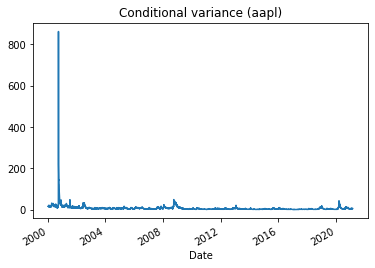

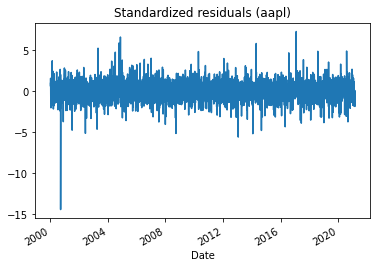

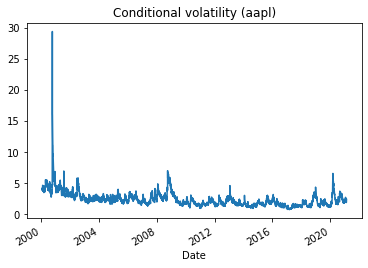

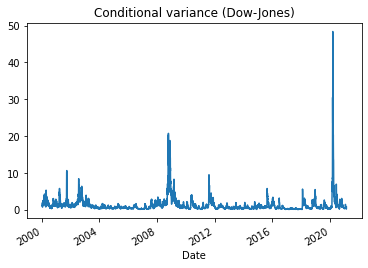

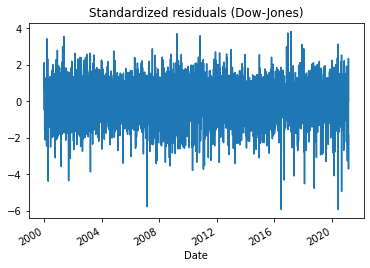

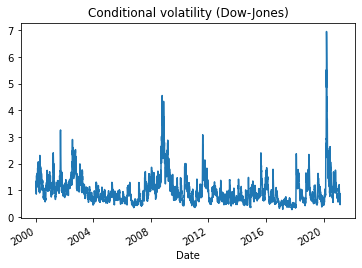

In [ ]:
# Plot the following:
# - Conditional variance
# - Standardized residuals
# - Conditional volatility (i.e. standard deviation)
def constructThings(model_res, params, name):
  conditional_variance = model_res.conditional_volatility ** 2
  conditional_variance.plot()
  plt.title('Conditional variance (%s)' % name)
  plt.show()
  standardized_residuals = model_res.std_resid
  standardized_residuals.plot()
  plt.title('Standardized residuals (%s)' % name)
  plt.show()
  conditional_volatility = np.sqrt(conditional_variance)
  conditional_volatility.plot()
  plt.title('Conditional volatility (%s)' % name)
  plt.show()
  
constructThings(aapl_model, aapl_params, 'aapl')
constructThings(djia_model, djia_model, 'Dow-Jones')
s1 = aapl_model.conditional_volatility
s2 = djia_model.conditional_volatility

We extracted the variance, the standardized residuals and the conditional volatility from both models, and plotted them above. We then constructed the conditional standard deviviation from both models s1 (aapl), and s2 (djia).

##2

In [ ]:
y1_r = pandas2ri.py2rpy(y1)   # Transfrom to R dataframe
y1_r = robjects.r.matrix(y1_r, nrow=len(y1_r))  # R matrix, need to specify number of rows
y2_r = pandas2ri.py2rpy(y2)   # Transfrom to R dataframe
y2_r = robjects.r.matrix(y2_r, nrow=len(y2_r))  # R matrix, need to specify number of rows

In [ ]:
# ARMA(9,1)-EGARCH(2,2)
armaorder = robjects.r.matrix(robjects.FloatVector([9,1]), nrow=1)  # a 1x2 R matrix
meanModel = robjects.ListVector({'armaOrder': armaorder, 'include.mean': True})
garchorder = robjects.r.matrix(robjects.FloatVector([2,2]), nrow=1)  # a 1x2 R matrix
varianceModel = robjects.ListVector({'model': 'eGARCH', 'garchOrder': garchorder})
garchspec_r = rugarch.ugarchspec(mean_model = meanModel, variance_model=varianceModel, distribution_model='norm')
uspec = rugarch.multispec([garchspec_r, garchspec_r])  # Use the spec object
dcc_spec = rmgarch.dccspec(uspec, model='DCC', distribution='mvnorm')  # DCC model specification
Y_r = base.cbind(y1_r, y2_r)
dcc_fit = rmgarch.dccfit(dcc_spec, data=Y_r)

In [ ]:
print(methods.show(dcc_fit))  # Print output
print(base.attributes(dcc_fit.slots['model'])[0])  # Output under 'model'
print(base.attributes(dcc_fit.slots['mfit'])[0])  # Output under 'mfit'



*---------------------------------*
*          DCC GARCH Fit          *
*---------------------------------*

Distribution         :  mvnorm
Model                :  DCC(1,1)
No. Parameters       :  39
[VAR GARCH DCC UncQ] : [0+36+2+1]
No. Series           :  2
No. Obs.             :  5321
Log-Likelihood       :  -17877.51
Av.Log-Likelihood    :  -3.36 

Optimal Parameters
-----------------------------------
                  Estimate  Std. Error     t value Pr(>|t|)
[Asset_1].mu      0.158675    0.021055    7.536230 0.000000
[Asset_1].ar1    -0.677824    0.006563 -103.280639 0.000000
[Asset_1].ar2     0.000271    0.000284    0.953814 0.340178
[Asset_1].ar3    -0.021859    0.004560   -4.794162 0.000002
[Asset_1].ar4     0.030864    0.006478    4.764080 0.000002
[Asset_1].ar5     0.050603    0.006571    7.700763 0.000000
[Asset_1].ar6    -0.003476    0.001526   -2.278462 0.022699
[Asset_1].ar7     0.005880    0.003933    1.494976 0.134921
[Asset_1].ar8    -0.036501    0.008931   -4.08711

We fiited a DCC using the the parameters estimated in part 1). The parameters alpha and beta we obtainedfrom the model are the following:
\begin{align*}
\alpha&= 0.030010\\
\beta&= 0.953735
\end{align*}
Note that this parameters are positive making $\Sigma_t$ positive definite.
The model has mean-reverting correlations as $\alpha$ + $\beta$ < 1. 

##3

In [ ]:
s_dcc = rugarch.sigma(dcc_fit)  # Note that this is an rugarch method
s_dcc = pd.DataFrame(s_dcc, index=df.index, columns=['s1 (DCC)','s2 (DCC)'])  # Convert to pandas DataFrame

In [ ]:
bekk_fit = mgarchBEKK.BEKK(Y_r,method="Nelder-Mead")

In [ ]:
print(bekk_fit.rx('est.params'))

$est.params
$est.params$`1`
         [,1]       [,2]
[1,] 1.313912 -0.2880730
[2,] 0.000000  0.2534199

$est.params$`2`
           [,1]       [,2]
[1,]  0.1896073 0.24278479
[2,] -0.1417066 0.04024274

$est.params$`3`
          [,1]       [,2]
[1,] 0.7422764 0.02899748
[2,] 0.5822842 0.77609737





We fitted a BEKK model using the default BEKK(1,1).

##4

In [ ]:
s_dcc = rugarch.sigma(dcc_fit)  # Note that this is an rugarch method
s_dcc = pd.DataFrame(s_dcc, index=df.index, columns=['s1 (DCC)','s2 (DCC)'])  # Convert to pandas DataFrame
rho_dcc_r = rmgarch.rcor(dcc_fit)[0,1,:]
rho_dcc = pd.Series(rho_dcc_r, index=df.index, name='rho')
print(s_dcc)
print(rho_dcc)

            s1 (DCC)  s2 (DCC)
Date                          
2000-01-04  2.651986  1.200090
2000-01-05  2.651986  1.200090
2000-01-06  3.637379  1.149356
2000-01-07  3.336220  1.066456
2000-01-10  4.752246  0.946991
...              ...       ...
2021-02-22  1.900399  0.632229
2021-02-23  2.132662  0.592677
2021-02-24  2.127574  0.561346
2021-02-25  1.954962  0.462251
2021-02-26  2.371221  0.860450

[5321 rows x 2 columns]
Date
2000-01-04    0.493040
2000-01-05    0.608349
2000-01-06    0.609226
2000-01-07    0.488068
2000-01-10    0.516795
                ...   
2021-02-22    0.357876
2021-02-23    0.335109
2021-02-24    0.337800
2021-02-25    0.286528
2021-02-26    0.425644
Name: rho, Length: 5321, dtype: float64


In [ ]:
s1_bekk = pd.Series(bekk_fit.rx2('sd')[0], index=df.index, name='s1')
s2_bekk = pd.Series(bekk_fit.rx2('sd')[1], index=df.index, name='s2')
rho_bekk = pd.Series(bekk_fit.rx2('cor')[1][0], index=df.index, name='rho')

We extracted the volatilies of both assets in both the DCC and BEKK models. Furthermore we also extracted the correlations (rho) results from both models.  

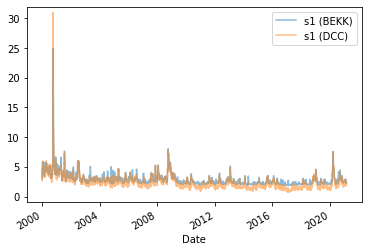

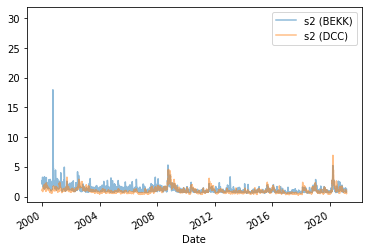

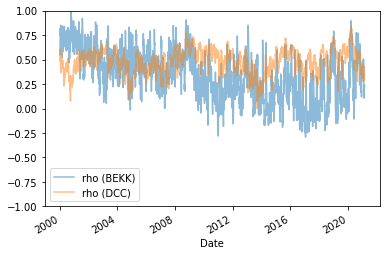

In [ ]:
s1_df = pd.DataFrame()
s1_df['s1 (BEKK)'] = s1_bekk
s1_df[['s1 (DCC)']] = s_dcc[['s1 (DCC)']]
s2_df =  pd.DataFrame()
s2_df ['s2 (BEKK)'] = s2_bekk
s2_df[['s2 (DCC)']]= s_dcc [['s2 (DCC)']]
# Plot S_1 from both models
s1_df.plot(alpha=0.5)
plt.ylim([-1, 32])
plt.show()
#Plot S_2 from both models
s2_df.plot(alpha=0.5)
plt.ylim([-1, 32])
plt.show()
rho_df = pd.DataFrame()
rho_df['rho (BEKK)'] = rho_bekk
rho_df['rho (DCC)'] = rho_dcc
rho_df.plot(alpha=0.5)
plt.ylim([-1, 1])
plt.show()


In the above we plotted the conditional volatilities of both models. We can the that the volatilies s1 (aapl) that the DCC an BEKK models produce are quite smilar, althought the volatility from the DCC model seems to have a higher peak around 2001. In terms of volatilies s2 (djia) the opposite happens where the BEKK model seems to have a higher peak since the spike is not even present in the DCC model. Also note that the BEKK model seems to produce volatilities slightly higher than the DCC model is both asssets. When comparing the volatilities of both assets we can see that aapl seems to have a much higher peak then djia around the year 2000, this is probably due to the .com bubble that affected mainly tech companies. 

In terms of the correlation coeffient produced by both models we can see that the results obtained for the BEKK model behave quite erradically, fluctuating much more than the correlations produced by the DCC model. Also, the BEKK model is the only one that produces negative values of volatility. 

##5.a)

In [ ]:
import statsmodels.regression.linear_model as srl
def EngleFTest(y1, y2, s1, s2, rho, name):
  z1 = y1/s1  #z1, z2 -> standardized residuals
  z2 = (y2/s2 - rho*y1/s1)/np.sqrt(1-rho**2)
  num_lags = 5
  regressors = np.zeros((3*num_lags, z1.size))
  for i in range(num_lags):
    regressors[i*3] = (z1**2).shift(i+1)
    regressors[i*3+1] = (z2**2).shift(i+1)
    regressors[i*3+2] = (z1*z2).shift(i+1)
  regressors = regressors.transpose()
  regressors = sm.add_constant(regressors)
  print(name, ': z1')
  res = sm.OLS(z1**2, regressors, missing='drop').fit()
  print(res.f_pvalue)
  print(name, ': z2')
  res = sm.OLS(z2**2, regressors, missing='drop').fit()
  print(res.f_pvalue)
  
EngleFTest(y1, y2, s_dcc['s1 (DCC)'], s_dcc['s2 (DCC)'], rho_dcc, 'DCC')
EngleFTest(y1, y2, s1_bekk, s2_bekk, rho_bekk, 'BEKK')

DCC : z1
0.782957405465678
DCC : z2
0.011873892208732384
BEKK : z1
0.8995454499017463
BEKK : z2
1.5576721987935561e-28


To test the fit of both the DCC and BEKK models we use the test described in Engle(2002). This specific test outlined in equation (39) is a test for  autocorrelation of the squared standardized
residuals. 

The test is computed as an $F$ test from the regression of z1
and z2, on five lags of the squares and cross products of the
standardized residuals plus an intercept. 

In the paper they reject the null hypothesis whenever the p value is smaller than $0.05$. For this case they have analyzed the effectiveness of the method on several different random processes with different conditional volatilities.

The DCC model seems has a p-value of around $0.78$ so we do not reject the hyphotesis that (the first component of) the squared standardized residuals of AAPL have no autocorrelation, while it has a p-value of less than $0.02$ for DJIA so we reject the null-hyphotesis for the second component. However at the 1% level we do not reject the null hypothesis.

The BEKK model seems to have a p-value $0.90$ so we do not reject the hyphotesis that the squared standardized residuals of AAPL have no autocorrelation while it has a p-value of far less than $0.01$ for DJIA so we reject the null-hyphotesis both at the 5% and 1% level.

So at a the $5\%$ level we can say that there is evidence of remaining time varying volatilities on the squared standardized residuals of DJIA after fitting both models. 

When looking at autocorrelation in the squared standardized residuals of AAPL both models seem to be a good fit. But the DCC model can be said to be better because the null hypothesis of there not being any more autocorrelation is not rejected at the 1% significance level.

#5.b)

In [ ]:
import statsmodels.regression.linear_model as srl
def EngleVaRTest(y1, y2, s1, s2, rho, name):
  w = 1/2
  var = 1.65 * np.sqrt(w ** 2 * (s1 ** 2) + (1-w) ** 2 * (s2 ** 2)  + 2 * w * (1-w) * rho * s1 * s2)
  hit = (w*y1+(1-w)*y2 < -var)-0.5
  num_lags = 5
  regressors = np.zeros((num_lags + 1, hit.size))
  regressors[0] = var
  for i in range(1,num_lags):
    regressors[i] = hit.shift(i)
  regressors = regressors.transpose()
  regressors = sm.add_constant(regressors)
  print(name, ': h')
  res = sm.OLS(hit, regressors, missing='drop').fit()
  print(res.f_pvalue)
  
EngleVaRTest(y1, y2, s_dcc ['s1 (DCC)'], s_dcc ['s2 (DCC)'], rho_dcc, 'DCC')
EngleVaRTest(y1, y2, s1_bekk, s2_bekk, rho_bekk, 'BEKK')

DCC : h
0.16221770204362712
BEKK : h
0.00014603298386383422


The third performance measure is about calculating value at risk for a portfolio with $\frac{1}{2}$
invested in the first asset and $\frac{1}{2}$ in the second. The hit variable is the indicator function of the portfolio value being smaller than -var.

We perform an $F$ test of the hypothesis that all coefficients as well
as the intercept are zero in a regression of the hit variable on five lags of its past and on current Var (and a constant).

From the resulting p-values we can see that the DCC model produces about a p-value of around $0.16$, so we do not reject the null-hyphotesis at a $5\%$ level. On the other hand, the results produced by the BEKK model indicate a p-value of less than $0.01$ so we do reject the null hyphotesis that all coefficients of this regression are zero. 

Overall, when it comes do this performance test, the DCC model performs better than the BEKK model because in the case of DCC we do not reject the null hypothesis of the estimator fully explaining the VaR while in the case of BEKK we do reject that null hypothesis.